<a href="https://colab.research.google.com/github/LezendarySandwich/CSL7550-Stock-Price-Prediction/blob/master/LSTM_TCS_Result_lipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt 

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

In [ ]:
from datetime import date

STORAGE = '/content/drive/MyDrive' #@param {type : "string"}
KAGGLE_DIR = 'Kaggle' #@param {type : "string"}
KAGGLE_JSON_PATH = os.path.join(STORAGE, KAGGLE_DIR)
QUANDL_PATH = os.path.join(KAGGLE_JSON_PATH, '.quandl')
__PROJECT = os.path.join(STORAGE, 'Neo')
ML_DATASET = os.path.join(__PROJECT, 'dataset')
START_DATE = date(2014, 1, 1)
END_DATE = date(2019,1,1)
STOCK = 'TCS'#@param {type : "string"}
SAVE_DIR = os.path.join(ML_DATASET, f'{STOCK}_{START_DATE}_{END_DATE}')
TEST_DS = os.path.join(SAVE_DIR,'dataset_test.csv')
TRAIN_DS = os.path.join(SAVE_DIR,'dataset_train.csv')

In [ ]:
train_df= pd.read_csv(TRAIN_DS)
test_df= pd.read_csv(TEST_DS)
train_df

,Date,Open,High,Low,Close,Volume
0,2014-01-01,2180.10,2184.50,2151.10,2153.30,264976.0
1,2014-01-02,2166.00,2189.00,2156.15,2167.00,863474.0
2,2014-01-03,2164.70,2229.10,2147.25,2222.20,1309087.0
3,2014-01-06,2229.00,2244.00,2197.00,2239.60,1155905.0
4,2014-01-07,2240.00,2256.45,2199.00,2206.15,1448743.0
...,...,...,...,...,...,...
982,2017-12-22,2604.00,2663.90,2590.20,2646.75,1832832.0
983,2017-12-26,2686.00,2689.75,2631.60,2649.45,1087893.0
984,2017-12-27,2649.45,2658.50,2610.50,2619.90,369642.0
985,2017-12-28,2608.80,2653.50,2605.65,2626.95,1302544.0


In [ ]:
train_dates_df= train_df['Date']
train_df= train_df.drop(columns=["Date"])
test_dates_df= test_df['Date']
test_df= test_df.drop(columns=['Date']) 

In [ ]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
import numpy as np

sc = MinMaxScaler(feature_range=(0,1), copy = True)
training_set_scaled = sc.fit_transform(train_df)
x_train = []
y_train = []

for i in range(60,len(train_df)):
    x_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train

array([[0.20013158, 0.18157895, 0.17986842, ..., 0.14335526, 0.15263158,
        0.15796053],
       [0.18157895, 0.17986842, 0.26447368, ..., 0.15263158, 0.15796053,
        0.09598684],
       [0.17986842, 0.26447368, 0.27894737, ..., 0.15796053, 0.09598684,
        0.09078947],
       ...,
       [0.59342105, 0.54210526, 0.55473684, ..., 0.73552632, 0.75789474,
        0.86578947],
       [0.54210526, 0.55473684, 0.54342105, ..., 0.75789474, 0.86578947,
        0.81769737],
       [0.55473684, 0.54342105, 0.52894737, ..., 0.86578947, 0.81769737,
        0.76421053]])

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
#Adding the first LSTM layer and some dropout regularization to avoid overfitting
regressor = Sequential()
#Add first LSTM layer
regressor.add(LSTM(units= 50, return_sequences=True, input_shape = (x_train.shape[1],1) )) #No of LSTM cells = units, return_sequences = True because we are building a stacked LSTM which will have several LSTM layers, when you are done adding LSTM layers set it to False whch is the default, input_shape (timesteps,predictors)
#Add dropout regularization
regressor.add(Dropout(rate = 0.2)) #rate of neurons you want to drop during regularization (during each iteration of the forward and back propagation)

#Add Second LSTM Layer and dropout regularization 
regressor.add(LSTM(units= 50, return_sequences=True )) #No of LSTM cells = units, return_sequences = True because we are building a stacked LSTM which will have several LSTM layers, when you are done adding LSTM layers set it to False whch is the default 
#Add dropout regularization
regressor.add(Dropout(rate = 0.2)) #rate of neurons you want to drop during regularization (during each iteration of the forward and back propagation)

#Add Third LSTM Layer and dropout regularization 
regressor.add(LSTM(units= 50, return_sequences=True )) #No of LSTM cells = units, return_sequences = True because we are building a stacked LSTM which will have several LSTM layers, when you are done adding LSTM layers set it to False whch is the default 
#Add dropout regularization
regressor.add(Dropout(rate = 0.2)) #rate of neurons you want to drop during regularization (during each iteration of the forward and back propagation)

#Add Fourth LSTM Layer and dropout regularization 
#return_sequences=False because this is our last LSTM layer
regressor.add(LSTM(units= 50, return_sequences=False )) #No of LSTM cells = units, return_sequences = True because we are done adding LSTM layers 
#Add dropout regularization
regressor.add(Dropout(rate = 0.2)) #rate of neurons you want to drop during regularization (during each iteration of the forward and back propagation)

#Add the output layer for full connection

regressor.add(Dense(units=1 ))

#Compiling the RNN

regressor.compile(optimizer="adam", loss = "mean_squared_error") #optimizer="rmsprop" recommended for RNN but adam is always a safe and good choice
#loss = "mean_squared_error" for regression 



In [ ]:
regressor.fit(x_train,y_train, epochs= 100, batch_size=32)

Epoch 1/100
29/29 [==============================] - 11s 129ms/step - loss: 0.0570
Epoch 2/100
29/29 [==============================] - 4s 131ms/step - loss: 0.0201
Epoch 3/100
29/29 [==============================] - 4s 130ms/step - loss: 0.0185
Epoch 4/100
29/29 [==============================] - 4s 133ms/step - loss: 0.0167
Epoch 5/100
29/29 [==============================] - 4s 134ms/step - loss: 0.0167
Epoch 6/100
29/29 [==============================] - 4s 132ms/step - loss: 0.0149
Epoch 7/100
29/29 [==============================] - 4s 130ms/step - loss: 0.0145
Epoch 8/100
29/29 [==============================] - 4s 131ms/step - loss: 0.0135
Epoch 9/100
29/29 [==============================] - 4s 132ms/step - loss: 0.0127
Epoch 10/100
29/29 [==============================] - 4s 132ms/step - loss: 0.0126
Epoch 11/100
29/29 [==============================] - 4s 130ms/step - loss: 0.0129
Epoch 12/100
29/29 [==============================] - 4s 131ms/step - loss: 0.0121
Epoch 13/100

In [ ]:
FUTURE_PREDICTION_RANGE = 60 #@param {type : "number"}
WINDOW = 60 #@param {type : "number"}

#Concatenating the training dataset and test dataset by row to form a total dataset
dataset_total = pd.concat((train_df["Open"], test_df["Open"]), axis = 0)

#Extract last 60 data from the training dataset + all the data from the test dataset (60 because we trained the model with 60 timesteps)
inputs = dataset_total[len(dataset_total) - len(test_df) - WINDOW:].values
inputs = inputs.reshape(-1,1)
#print(inputs)
#Feature Scaling
tmp=train_df["Open"].values
tmp=tmp.reshape(-1,1)
sc.fit(tmp)
inputs = sc.transform(inputs)
inputs

array([[ 0.54342105],
       [ 0.52894737],
       [ 0.54348684],
       [ 0.56184211],
       [ 0.56842105],
       [ 0.63815789],
       [ 0.68447368],
       [ 0.69348684],
       [ 0.73289474],
       [ 0.74605263],
       [ 0.74210526],
       [ 0.73157895],
       [ 0.77894737],
       [ 0.72434211],
       [ 0.66723684],
       [ 0.67105263],
       [ 0.73421053],
       [ 0.75434211],
       [ 0.78421053],
       [ 0.76381579],
       [ 0.79526316],
       [ 0.77894737],
       [ 0.84473684],
       [ 0.91447368],
       [ 0.95      ],
       [ 0.91342105],
       [ 0.88690789],
       [ 0.95861842],
       [ 0.89210526],
       [ 0.89736842],
       [ 0.9475    ],
       [ 0.90394737],
       [ 0.88552632],
       [ 0.84868421],
       [ 0.85921053],
       [ 0.86052632],
       [ 0.86842105],
       [ 0.86578947],
       [ 0.85460526],
       [ 0.82322368],
       [ 0.79868421],
       [ 0.78157895],
       [ 0.79342105],
       [ 0.8       ],
       [ 0.79513158],
       [ 0

In [ ]:
x_test = []
for i in range(WINDOW,WINDOW+FUTURE_PREDICTION_RANGE): #test data contains 80 rows of data
    x_test.append(inputs[i-WINDOW:i,0])

x_test  = np.array(x_test) 

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) #Converts to the 3d format that can go into the RNN as input
x_test

array([[[0.54342105],
        [0.52894737],
        [0.54348684],
        ...,
        [0.81769737],
        [0.76421053],
        [0.78302632]],

       [[0.52894737],
        [0.54348684],
        [0.56184211],
        ...,
        [0.76421053],
        [0.78302632],
        [0.86092105]],

       [[0.54348684],
        [0.56184211],
        [0.56842105],
        ...,
        [0.78302632],
        [0.86092105],
        [0.83157895]],

       ...,

       [[0.81769737],
        [0.76421053],
        [0.78302632],
        ...,
        [1.11118421],
        [1.09467105],
        [1.01842105]],

       [[0.76421053],
        [0.78302632],
        [0.86092105],
        ...,
        [1.09467105],
        [1.01842105],
        [1.04078947]],

       [[0.78302632],
        [0.86092105],
        [0.83157895],
        ...,
        [1.01842105],
        [1.04078947],
        [1.04868421]]])

In [ ]:
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price  = sc.inverse_transform(predicted_stock_price )

In [ ]:
predicted_stock_price.shape

(60, 1)

In [ ]:
real_stock_price= test_df['Open'].values[:FUTURE_PREDICTION_RANGE]
real_stock_price=real_stock_price.reshape(-1,1)
real_stock_price.shape

(60, 1)

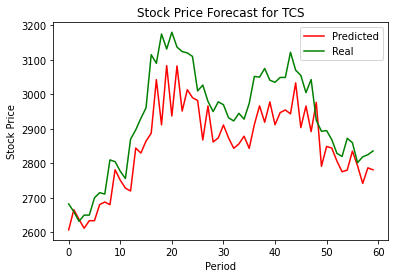

In [ ]:
plt.plot(predicted_stock_price, color="red", label= "Predicted")
plt.plot(real_stock_price, color="green", label= "Real")
plt.xlabel("Period")
plt.ylabel("Stock Price")
plt.title(f'Stock Price Forecast for {STOCK}')
plt.legend()
plt.show()

In [ ]:
#Model Evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math 



MAE_RNN = mean_absolute_error(real_stock_price,predicted_stock_price) #8.477951782226564

MSE_RNN = mean_squared_error(real_stock_price,predicted_stock_price) #131.51032080751082

RMSE_RNN = math.sqrt(MSE_RNN) #11.467794940942692

R2_RNN = r2_score(real_stock_price,predicted_stock_price) #0.39490875968951855

real_stock_price_mean = real_stock_price.mean()  #807.5260000000001


print("Mean Absolute Error:", MAE_RNN)
print("Mean Squared Error:", MSE_RNN)
print("Root Mean Squared Error:", RMSE_RNN)
print("R Squared:", R2_RNN)
print("Real Stock Price Mean:", real_stock_price_mean)
print("RMSE_RNN/REAL_STOCK_PRICE_MEAN:", RMSE_RNN/real_stock_price_mean) #0.014201146391500325

print("mean_absolute_percentage_error :", MAE_RNN/real_stock_price_mean *100 , " %")

Mean Absolute Error: 81.92623372395835
Mean Squared Error: 10213.508514631909
Root Mean Squared Error: 101.06190436871803
R Squared: 0.5252175467059239
Real Stock Price Mean: 2931.6208333333334
RMSE_RNN/REAL_STOCK_PRICE_MEAN: 0.034473047544080884
mean_absolute_percentage_error : 2.794571275808747  %


In [ ]:
FUTURE_PREDICTION_RANGE =  15 #@param {type : "number"}

In [ ]:
predicted_stock_price=[]
hist= dataset_total[len(train_df)-WINDOW:].values
hist= hist[:WINDOW]
hist= hist.reshape(-1,1)
sc.fit(tmp)
#print(hist)
hist= sc.transform(hist)
hist= hist.reshape(1,-1)[0]
hist=list(hist)
hist

for i in range(0,FUTURE_PREDICTION_RANGE):
  cur_win= hist[i:]
  #print(len(cur_win))
  cur_win= np.array(cur_win)
  cur_win.reshape(-1,1)
  cur_inp=list()
  cur_inp.append(cur_win)
  cur_inp= np.array(cur_inp)
  cur_inp= cur_inp.reshape(cur_inp.shape[0],cur_inp.shape[1],1)
  cur_p = regressor.predict(cur_inp)
  hist.append(cur_p[0][0])
  predicted_stock_price.append(cur_p[0][0])

predicted_stock_price= np.array(predicted_stock_price)
predicted_stock_price= predicted_stock_price.reshape(-1,1)
predicted_stock_price  = sc.inverse_transform(predicted_stock_price )
predicted_stock_price.shape

(15, 1)

In [ ]:
real_stock_price= test_df['Open'].values[:FUTURE_PREDICTION_RANGE]
real_stock_price=real_stock_price.reshape(-1,1)
real_stock_price.shape

(15, 1)

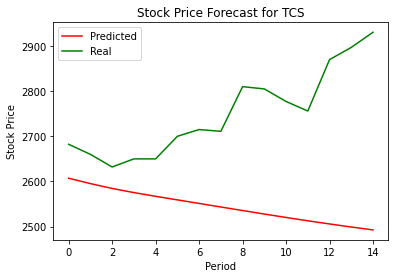

In [ ]:
plt.plot(predicted_stock_price, color="red", label= "Predicted")
plt.plot(real_stock_price, color="green", label= "Real")
plt.xlabel("Period")
plt.ylabel("Stock Price")
plt.title(f'Stock Price Forecast for {STOCK}')
plt.legend()
plt.show()

In [ ]:
#Model Evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math 



MAE_RNN = mean_absolute_error(real_stock_price,predicted_stock_price) #8.477951782226564

MSE_RNN = mean_squared_error(real_stock_price,predicted_stock_price) #131.51032080751082

RMSE_RNN = math.sqrt(MSE_RNN) #11.467794940942692

R2_RNN = r2_score(real_stock_price,predicted_stock_price) #0.39490875968951855

real_stock_price_mean = real_stock_price.mean()  #807.5260000000001


print("Mean Absolute Error:", MAE_RNN)
print("Mean Squared Error:", MSE_RNN)
print("Root Mean Squared Error:", RMSE_RNN)
print("R Squared:", R2_RNN)
print("Real Stock Price Mean:", real_stock_price_mean)
print("RMSE_RNN/REAL_STOCK_PRICE_MEAN:", RMSE_RNN/real_stock_price_mean) #0.014201146391500325

print("mean_absolute_percentage_error :", MAE_RNN/real_stock_price_mean *100 , " %")

Mean Absolute Error: 204.62524414062503
Mean Squared Error: 57300.846989194724
Root Mean Squared Error: 239.3759532392398
R Squared: -5.722419159447656
Real Stock Price Mean: 2749.733333333333
RMSE_RNN/REAL_STOCK_PRICE_MEAN: 0.08705424280144977
mean_absolute_percentage_error : 7.441639582285253  %
